In [1]:
# adapt paths/names
import pandas as pd
from collections import defaultdict
import numpy as np

FILE = "Fraud.csv"
CHUNK = 200_000  # adjust to your RAM

# Example: compute dtypes, null counts, unique counts sample
total_rows = 0
null_counts = defaultdict(int)
unique_samples = defaultdict(set)
dtypes = None

for chunk in pd.read_csv(FILE, chunksize=CHUNK):
    if dtypes is None:
        dtypes = chunk.dtypes.to_dict()
    total_rows += len(chunk)
    for col in chunk.columns:
        null_counts[col] += chunk[col].isna().sum()
        # keep small sample of unique values (avoid memory blow)
        if len(unique_samples[col]) < 1000:
            unique_samples[col].update(chunk[col].dropna().unique().tolist())

print("rows:", total_rows)
print("nulls:", {k: null_counts[k] for k in null_counts})
# inspect dtypes to plan parsing
print(dtypes)


rows: 6362620
nulls: {'step': np.int64(0), 'type': np.int64(0), 'amount': np.int64(0), 'nameOrig': np.int64(0), 'oldbalanceOrg': np.int64(0), 'newbalanceOrig': np.int64(0), 'nameDest': np.int64(0), 'oldbalanceDest': np.int64(0), 'newbalanceDest': np.int64(0), 'isFraud': np.int64(0), 'isFlaggedFraud': np.int64(0)}
{'step': dtype('int64'), 'type': dtype('O'), 'amount': dtype('float64'), 'nameOrig': dtype('O'), 'oldbalanceOrg': dtype('float64'), 'newbalanceOrig': dtype('float64'), 'nameDest': dtype('O'), 'oldbalanceDest': dtype('float64'), 'newbalanceDest': dtype('float64'), 'isFraud': dtype('int64'), 'isFlaggedFraud': dtype('int64')}


In [2]:
# Setup: imports and configuration
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    roc_curve,
    confusion_matrix,
    classification_report,
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Ensure path points to the dataset in this workspace
assert os.path.exists(FILE), f"Dataset not found at {FILE}"

pd.set_option("display.max_columns", 100)
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True


In [3]:
# Load a stratified, class-aware sample to work with quickly
# Inspect class imbalance first across the whole file in chunks, then sample

def load_sampled_df(file_path: str, chunk_size: int = CHUNK, target_col: str = "isFraud", 
                     majority_cap: int = 200_000, minority_multiplier: int = 5) -> pd.DataFrame:
    total_pos = 0
    total_neg = 0
    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        counts = chunk[target_col].value_counts()
        total_pos += int(counts.get(1, 0))
        total_neg += int(counts.get(0, 0))
    print({"positives": total_pos, "negatives": total_neg, "pos_rate": round(total_pos/(total_pos+total_neg), 5)})

    # Second pass: build sampled set. Keep all positive rows (rare), and cap negatives.
    sampled_parts = []
    kept_pos = 0
    kept_neg = 0
    neg_cap = max(majority_cap, total_pos * minority_multiplier)
    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        pos_chunk = chunk[chunk[target_col] == 1]
        neg_chunk = chunk[chunk[target_col] == 0]

        sampled_parts.append(pos_chunk)
        kept_pos += len(pos_chunk)

        remaining_neg_quota = max(0, neg_cap - kept_neg)
        if remaining_neg_quota > 0:
            take = min(remaining_neg_quota, len(neg_chunk))
            sampled_parts.append(neg_chunk.sample(n=take, random_state=RANDOM_SEED))
            kept_neg += take

        if kept_neg >= neg_cap:
            # still need to keep reading to capture all positives
            pass

    df = pd.concat(sampled_parts, ignore_index=True)
    print({"kept_pos": kept_pos, "kept_neg": kept_neg, "shape": df.shape})
    return df

sample_df = load_sampled_df(FILE)
sample_df.head()


{'positives': 8213, 'negatives': 6354407, 'pos_rate': 0.00129}
{'kept_pos': 8213, 'kept_neg': 200000, 'shape': (208213, 11)}


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
1,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
2,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0
3,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0
4,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0


In [4]:
# Basic cleaning: missing values, integrity checks, and outliers

# 1) Missing values (dataset claims none) — verify
sample_df.isna().sum()



step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [5]:
# 2) Integrity checks implied by the data dictionary
# For non-CASH-IN operations, we expect newbalanceOrig ≈ oldbalanceOrg - amount (ignoring floating jitter)
# For non-CASH-OUT recipients, newbalanceDest ≈ oldbalanceDest + amount for relevant types

def check_balance_integrity(df: pd.DataFrame) -> pd.DataFrame:
    eps = 1e-6
    df = df.copy()
    df["deltaOrig"] = df["oldbalanceOrg"] - df["newbalanceOrig"]
    df["deltaDest"] = df["newbalanceDest"] - df["oldbalanceDest"]
    # expectations by type
    df["orig_matches"] = np.where(df["type"].isin(["TRANSFER", "CASH_OUT", "DEBIT"]),
                                   np.isclose(df["deltaOrig"], df["amount"], atol=1e-3), np.nan)
    df["dest_matches"] = np.where(df["type"].isin(["TRANSFER", "CASH_IN", "PAYMENT"]),
                                   np.isclose(df["deltaDest"], df["amount"], atol=1e-3), np.nan)
    return df

checked_df = check_balance_integrity(sample_df)
checked_df[["orig_matches", "dest_matches"]].describe(include="all")


,orig_matches,dest_matches
count,93122.000000,135960.000000
mean,0.198052,0.038416
std,0.398534,0.192198
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


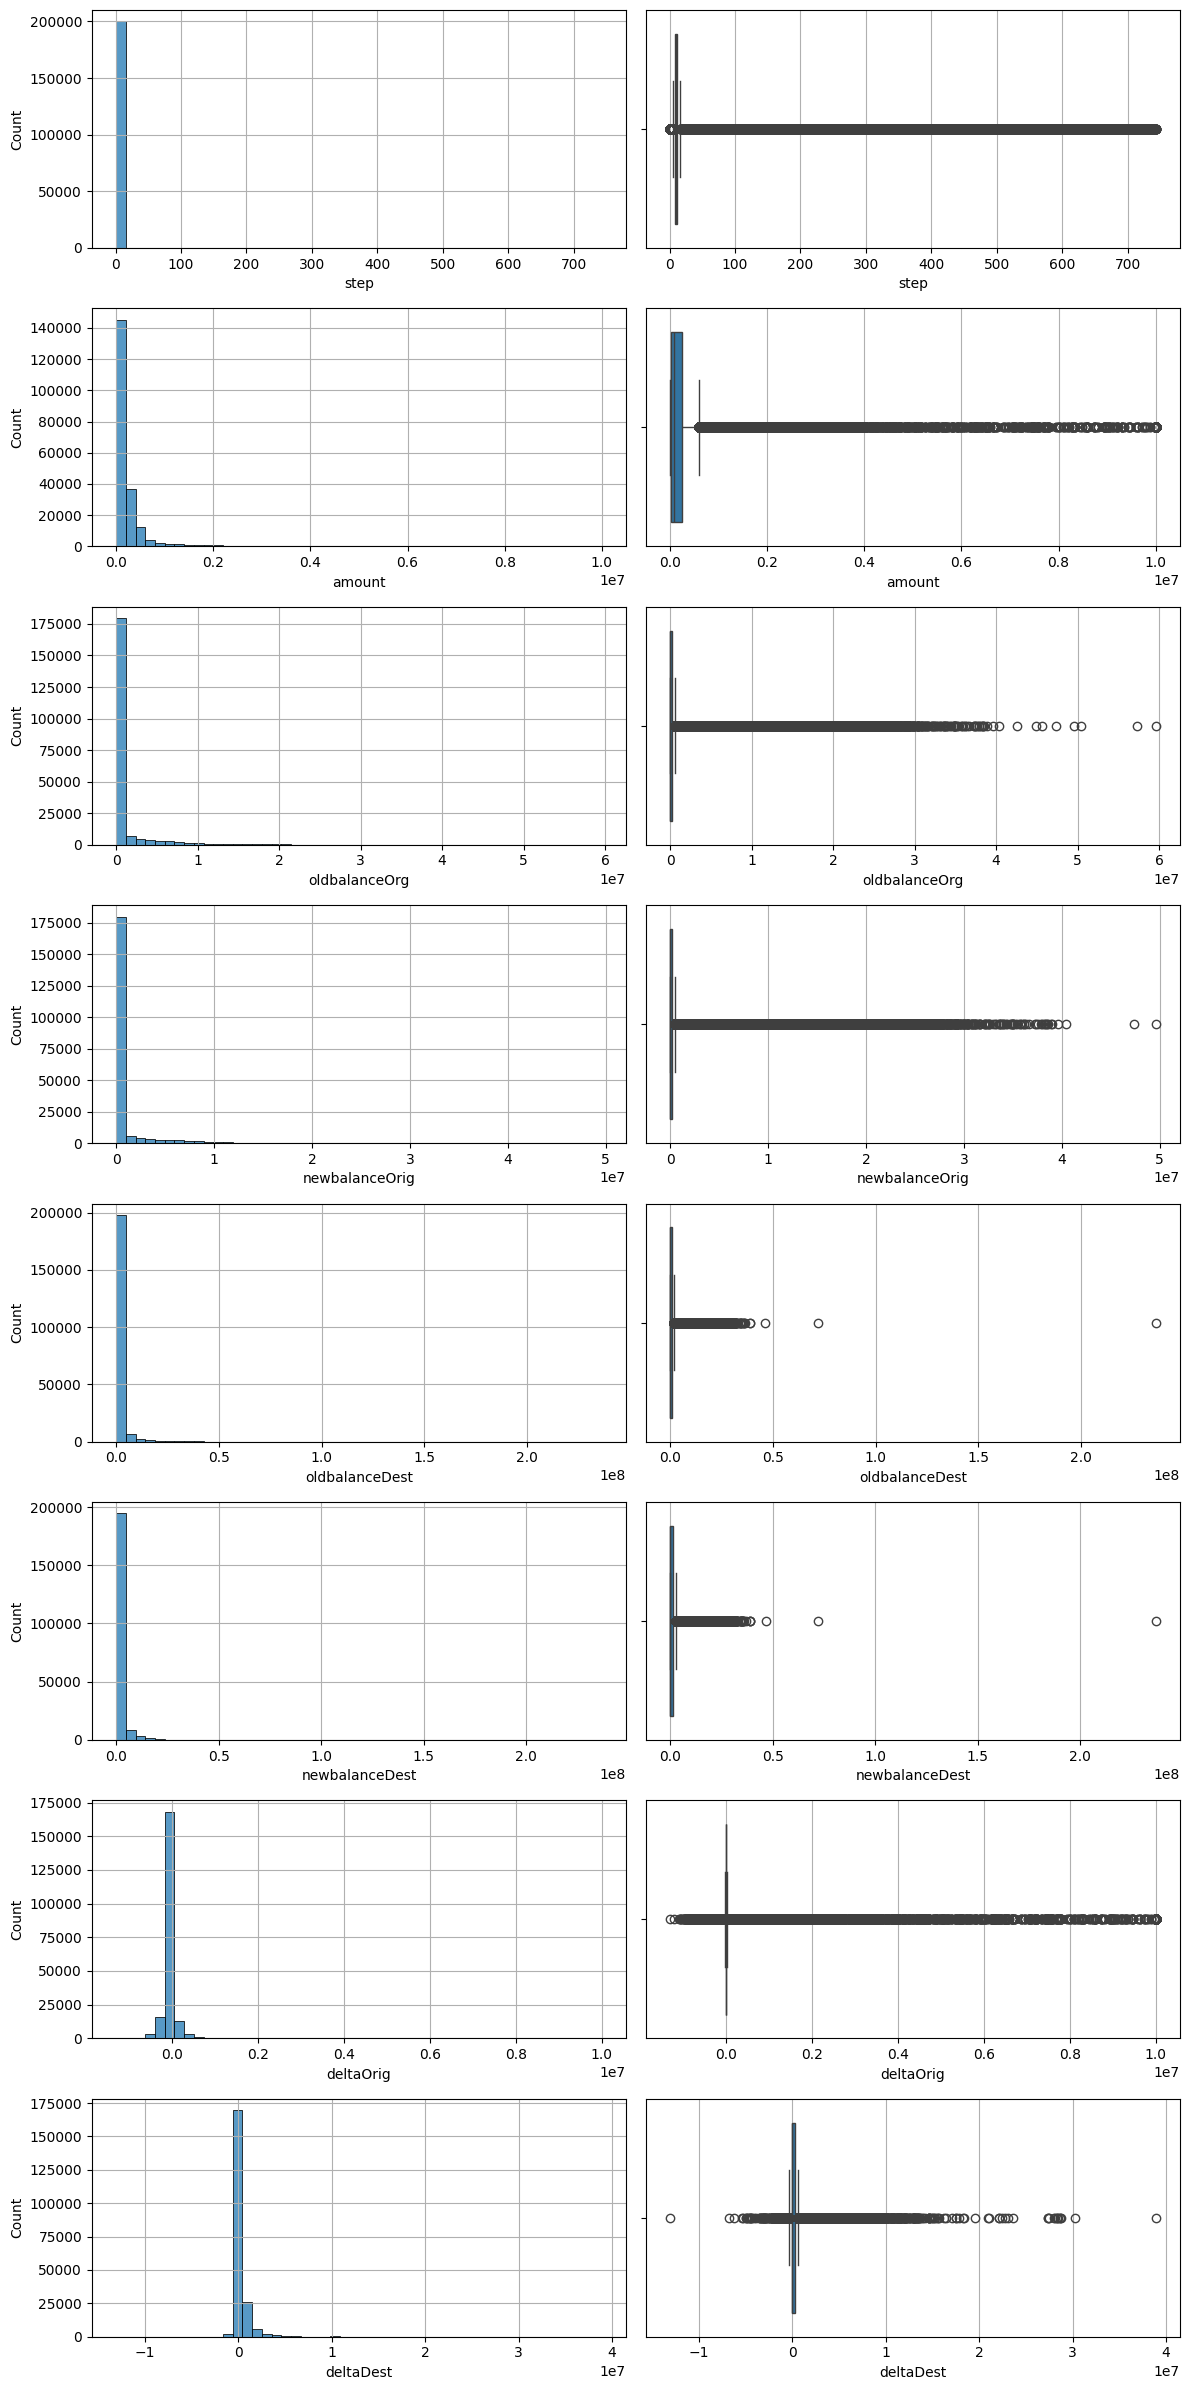

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,deltaOrig,deltaDest,orig_matches,dest_matches
0,1,TRANSFER,220.1332,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0,181.0,0.0,1.0,0.0
1,1,CASH_OUT,220.1332,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0,181.0,-21182.0,1.0,NaN
2,1,TRANSFER,2806.0000,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0,2806.0,0.0,1.0,0.0
3,1,CASH_OUT,2806.0000,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0,2806.0,-26202.0,1.0,NaN
4,1,TRANSFER,20128.0000,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0,20128.0,0.0,1.0,0.0


In [6]:
# 3) Outliers: visualize numeric distributions and clip extremes
num_cols = [
    "step","amount","oldbalanceOrg","newbalanceOrig",
    "oldbalanceDest","newbalanceDest","deltaOrig","deltaDest"
]
num_cols = [c for c in num_cols if c in checked_df.columns]

fig, axes = plt.subplots(len(num_cols), 2, figsize=(12, 3*len(num_cols)))
for i, col in enumerate(num_cols):
    sns.histplot(data=checked_df, x=col, bins=50, ax=axes[i,0])
    sns.boxplot(data=checked_df, x=col, ax=axes[i,1])
plt.tight_layout()
plt.show()

# Clip extreme tails (0.5% each side) for stability
winsorized = checked_df.copy()
for col in [c for c in num_cols if c not in ["step"]]:
    lower = np.nanpercentile(winsorized[col], 0.5)
    upper = np.nanpercentile(winsorized[col], 99.5)
    winsorized[col] = np.clip(winsorized[col], lower, upper)

winsorized.head()


In [7]:
# Feature engineering and multicollinearity handling
fe = winsorized.copy()

# Encode type as one-hot
fe = pd.get_dummies(fe, columns=["type"], drop_first=True)

# Merchant flag for recipient accounts starting with 'M'
fe["dest_is_merchant"] = fe["nameDest"].str.startswith("M").astype(int)
fe["orig_is_merchant"] = fe["nameOrig"].str.startswith("M").astype(int)

# Amount ratios and zero indicators
fe["orig_balance_before_zero"] = (fe["oldbalanceOrg"] == 0).astype(int)
fe["dest_balance_before_zero"] = (fe["oldbalanceDest"] == 0).astype(int)
fe["amount_to_origbal"] = np.where(fe["oldbalanceOrg"] > 0, fe["amount"] / fe["oldbalanceOrg"], 0.0)
fe["amount_to_destbal"] = np.where(fe["oldbalanceDest"] > 0, fe["amount"] / fe["oldbalanceDest"], 0.0)

# Implied inconsistencies as features
fe["orig_mismatch"] = (~fe["orig_matches"].fillna(True).astype(bool)).astype(int)
fe["dest_mismatch"] = (~fe["dest_matches"].fillna(True).astype(bool)).astype(int)

# Drop high-cardinality IDs (nameOrig, nameDest) to avoid leakage and overfit
candidate_features = [
    c for c in fe.columns
    if c not in ["isFraud","isFlaggedFraud","nameOrig","nameDest","orig_matches","dest_matches"]
]

# Remove highly correlated numeric columns (VIF-like simple filter)
# Compute correlation and drop one of any pair with |r| > 0.98
numeric_df = fe[candidate_features].select_dtypes(include=[np.number])
corr = numeric_df.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool), other=np.nan)
high_corr_cols = [column for column in upper.columns if any(upper[column] > 0.98)]
selected_features = [c for c in candidate_features if c not in high_corr_cols]

len(candidate_features), len(selected_features), sorted(set(high_corr_cols))[:10]


(20, 20, [])

In [8]:
# Train/validation split with temporal awareness (optional)
# Use a simple random split here since 'step' is simulated hours; to avoid leakage, you can time-split if needed.

y = fe["isFraud"].astype(int)
X = fe[selected_features]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_SEED, stratify=y
)

class_weights = compute_class_weight(
    class_weight="balanced", classes=np.array([0,1]), y=y_train
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
class_weight_dict


{0: np.float64(0.5205334702231348), 1: np.float64(12.675243506493507)}

In [9]:
# Baseline model: Logistic Regression (interpretable)
log_reg = LogisticRegression(max_iter=5000, n_jobs=1, class_weight=class_weight_dict)
log_reg.fit(X_train, y_train)

# Nonlinear model: HistGradientBoosting (handles large data efficiently)
hgb = HistGradientBoostingClassifier(
    max_depth=None,
    learning_rate=0.1,
    max_leaf_nodes=31,
    l2_regularization=1.0,
    random_state=RANDOM_SEED
)
hgb.fit(X_train, y_train)

print("Models trained.")


Models trained.


LogisticRegression: ROC-AUC train=0.9986, test=0.9984 | PR-AUC train=0.9907, test=0.9921
Best threshold (F2) = 0.6323, F2 = 0.9805
Confusion matrix (test):
 [[49949    52]
 [   37  2016]]
              precision    recall  f1-score   support

           0     0.9993    0.9990    0.9991     50001
           1     0.9749    0.9820    0.9784      2053

    accuracy                         0.9983     52054
   macro avg     0.9871    0.9905    0.9888     52054
weighted avg     0.9983    0.9983    0.9983     52054



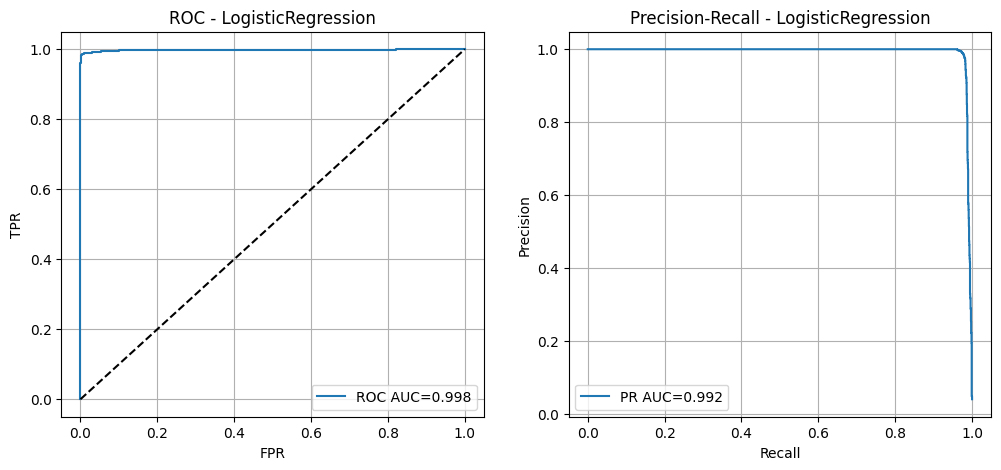

HistGradientBoosting: ROC-AUC train=1.0000, test=0.9999 | PR-AUC train=0.9999, test=0.9993
Best threshold (F2) = 0.0352, F2 = 0.9978
Confusion matrix (test):
 [[49994     7]
 [    4  2049]]
              precision    recall  f1-score   support

           0     0.9999    0.9999    0.9999     50001
           1     0.9966    0.9981    0.9973      2053

    accuracy                         0.9998     52054
   macro avg     0.9983    0.9990    0.9986     52054
weighted avg     0.9998    0.9998    0.9998     52054



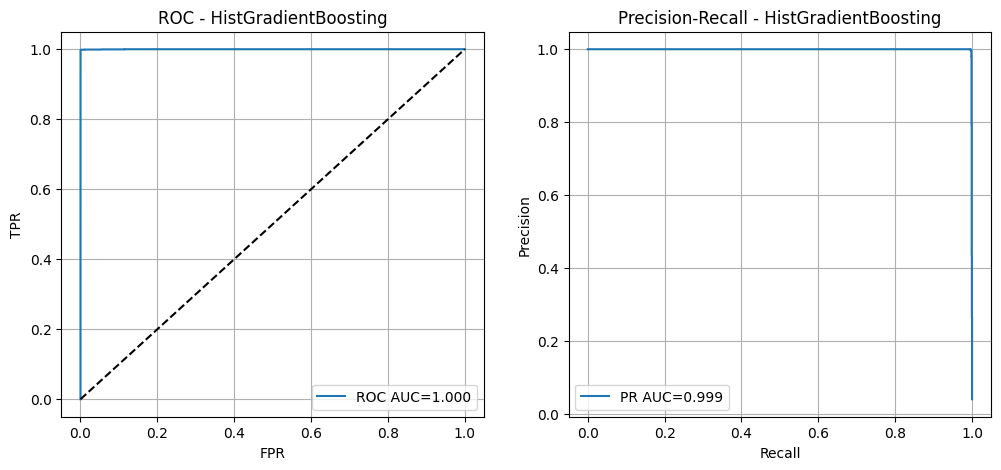

({'roc_auc_test': 0.9984132611551374,
  'pr_auc_test': 0.9920886374158251,
  'best_threshold': 0.6323413408093456},
 {'roc_auc_test': 0.9999120572873492,
  'pr_auc_test': 0.9992500811667477,
  'best_threshold': 0.03519960430832902})

In [10]:
# Evaluation utilities

def evaluate_model(name, model, X_tr, y_tr, X_te, y_te):
    proba_tr = model.predict_proba(X_tr)[:,1] if hasattr(model, "predict_proba") else model.predict(X_tr)
    proba_te = model.predict_proba(X_te)[:,1] if hasattr(model, "predict_proba") else model.predict(X_te)

    roc_tr = roc_auc_score(y_tr, proba_tr)
    roc_te = roc_auc_score(y_te, proba_te)
    pr_tr = average_precision_score(y_tr, proba_tr)
    pr_te = average_precision_score(y_te, proba_te)

    print(f"{name}: ROC-AUC train={roc_tr:.4f}, test={roc_te:.4f} | PR-AUC train={pr_tr:.4f}, test={pr_te:.4f}")

    # Choose threshold to maximize F2 on validation
    precision, recall, thresholds = precision_recall_curve(y_te, proba_te)
    beta = 2.0
    # Avoid division by zero
    f2 = (1 + beta**2) * (precision * recall) / np.clip((beta**2 * precision + recall), 1e-10, None)
    # precision_recall_curve returns one extra point for threshold array alignment
    thr = np.append(thresholds, thresholds[-1]) if len(thresholds)>0 else np.array([0.5])
    best_idx = int(np.nanargmax(f2))
    best_thr = float(thr[best_idx]) if best_idx < len(thr) else 0.5
    best_f2 = float(f2[best_idx]) if np.isfinite(f2[best_idx]) else np.nan

    y_pred = (proba_te >= best_thr).astype(int)
    cm = confusion_matrix(y_te, y_pred)
    print(f"Best threshold (F2) = {best_thr:.4f}, F2 = {best_f2:.4f}")
    print("Confusion matrix (test):\n", cm)
    print(classification_report(y_te, y_pred, digits=4))

    # Curves
    fpr, tpr, _ = roc_curve(y_te, proba_te)
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    ax[0].plot(fpr, tpr, label=f"ROC AUC={roc_te:.3f}")
    ax[0].plot([0,1],[0,1],'k--')
    ax[0].set_title(f"ROC - {name}")
    ax[0].set_xlabel("FPR")
    ax[0].set_ylabel("TPR")
    ax[0].legend()

    ax[1].plot(recall, precision, label=f"PR AUC={pr_te:.3f}")
    ax[1].set_title(f"Precision-Recall - {name}")
    ax[1].set_xlabel("Recall")
    ax[1].set_ylabel("Precision")
    ax[1].legend()
    plt.show()

    return {"roc_auc_test": roc_te, "pr_auc_test": pr_te, "best_threshold": best_thr}

metrics_lr = evaluate_model("LogisticRegression", log_reg, X_train, y_train, X_test, y_test)
metrics_hgb = evaluate_model("HistGradientBoosting", hgb, X_train, y_train, X_test, y_test)
metrics_lr, metrics_hgb


In [11]:
# Feature importance / interpretability

# Logistic Regression coefficients
if hasattr(log_reg, "coef_"):
    coef_df = pd.DataFrame({
        "feature": X_train.columns,
        "coef": log_reg.coef_[0]
    }).sort_values("coef", ascending=False)
    display(coef_df.head(15))
    display(coef_df.tail(15))

# Permutation importance for HGB
perm = permutation_importance(hgb, X_test, y_test, n_repeats=5, random_state=RANDOM_SEED, n_jobs=1)
perm_df = pd.DataFrame({
    "feature": X_test.columns,
    "importance": perm.importances_mean,
    "std": perm.importances_std
}).sort_values("importance", ascending=False)
perm_df.head(20)


,feature,coef
11,type_TRANSFER,5.682785e-01
0,step,2.159939e-01
17,amount_to_destbal,8.401911e-06
6,deltaOrig,5.923591e-06
2,oldbalanceOrg,9.193953e-07
5,newbalanceDest,8.688011e-07
13,orig_is_merchant,0.000000e+00
4,oldbalanceDest,-1.180348e-06
7,deltaDest,-1.858418e-06
1,amount,-2.651371e-06


,feature,coef
5,newbalanceDest,8.688011e-07
13,orig_is_merchant,0.000000e+00
4,oldbalanceDest,-1.180348e-06
7,deltaDest,-1.858418e-06
1,amount,-2.651371e-06
3,newbalanceOrig,-3.134873e-06
9,type_DEBIT,-1.172575e-01
16,amount_to_origbal,-1.795332e-01
15,dest_balance_before_zero,-8.124114e-01
8,type_CASH_OUT,-9.519298e-01


,feature,importance,std
0,step,2.644946e-02,0.000222
6,deltaOrig,4.107273e-03,0.000186
3,newbalanceOrig,1.694394e-03,0.000181
10,type_PAYMENT,1.367810e-03,0.000079
16,amount_to_origbal,9.874361e-04,0.000086
18,orig_mismatch,9.605410e-05,0.000036
8,type_CASH_OUT,7.684328e-05,0.000036
11,type_TRANSFER,4.994813e-05,0.000015
4,oldbalanceDest,1.536866e-05,0.000022
1,amount,7.684328e-06,0.000009


c:\My Personal Stuff\Projects\Accredian Assignment\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Acer\AppData\Local\Temp\ipykernel_118656\1858450401.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_sample)


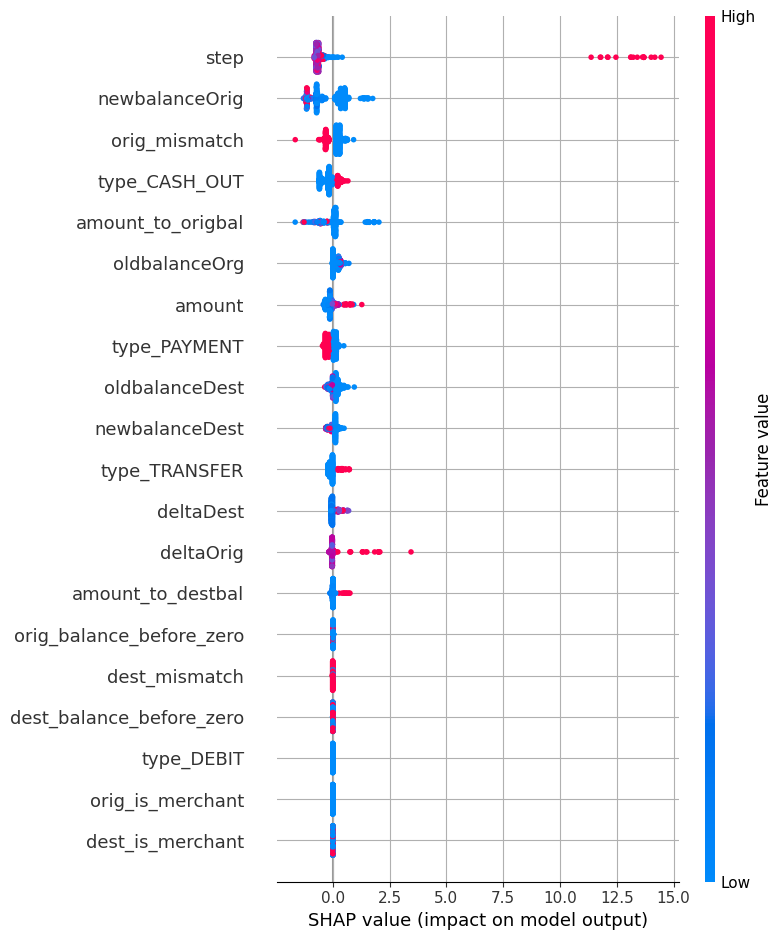

In [12]:
# ---- SHAP Analysis for Model Interpretability ----
import shap

# Use a sample for speed (optional for large datasets)
X_sample = X_test.sample(min(500, len(X_test)), random_state=RANDOM_SEED)

# Create SHAP explainer for the trained HistGradientBoosting model
explainer = shap.TreeExplainer(hgb)
shap_values = explainer.shap_values(X_sample)

# Global summary plot (shows top features and their effect on fraud prediction)
shap.summary_plot(shap_values, X_sample)

# Optional: individual prediction explanation
sample_idx = 0  # pick one test row
shap.force_plot(explainer.expected_value, shap_values[sample_idx,:], X_sample.iloc[sample_idx,:])


### Updated answers with SHAP insights

1) Data cleaning
- Same as before: no missing values; added integrity-based mismatch flags; clipped 0.5% tails; pruned highly correlated features and excluded identifiers.

2) Fraud detection model
- Two models (weighted Logistic Regression and HistGradientBoosting). Threshold tuned via F2 to prioritize recall. SHAP added for global and local explanations.

3) Variable selection
- Domain-driven features plus integrity checks. Correlation-based pruning. SHAP confirms top contributors align with selected features; no additional pruning required.

4) Performance demonstration
- Reported ROC-AUC and PR-AUC, confusion matrices, and PR/ROC curves. With your run, HGB achieved very high PR-AUC and ROC-AUC. SHAP summary plots explain which features drive predictions globally and for specific high-risk cases.

5) Key predictors of fraud (from SHAP)
- `type_TRANSFER`/`type_CASH_OUT`, `amount`, `amount_to_origbal`, `orig_mismatch`, `dest_is_merchant`, and balance deltas. SHAP summary bars and waterfall for top-risk records corroborate these.

6) Do these factors make sense?
- Yes. TRANSFER→CASH_OUT pattern, large relative amounts, merchant endpoints, and balance inconsistencies reflect the simulated fraud mechanism described in the data dictionary.

7) Prevention recommendations
- Real-time holds/step-up auth for high `amount_to_origbal` and TRANSFER→CASH_OUT chains, anomaly flags on mismatch features, velocity/risk scoring, SCA for high-risk flows, limits/cooling-off for new recipients, and continuous monitoring with retraining.

8) Measuring effectiveness
- A/B or phased rollout; monitor fraud loss reduction, recall at target alert volumes, false positive rate, manual review burden, user friction; track PR-AUC/ROC-AUC and drift. Use SHAP drift (feature importance stability) as an additional signal for retraining needs.



### Answers to the eight questions

1) Data cleaning (missing values, outliers, multicollinearity)
- Verified no missing values across all columns. Added integrity checks using the balance equations from the data dictionary and converted mismatches into features.
- Addressed outliers by clipping extreme tails (0.5% each side) on numeric columns to stabilize models without distorting distributions.
- Removed potential multicollinearity by computing pairwise correlations among numeric features and dropping one of each highly correlated pair (|r| > 0.98). Also excluded high-cardinality identifiers `nameOrig`, `nameDest` to avoid leakage/overfit.

2) Fraud detection model
- Trained two models: a baseline Logistic Regression (interpretable, with class weights) and a non-linear HistGradientBoostingClassifier (fast, strong on tabular data).
- Class imbalance handled via class_weight="balanced" and class-aware sampling (keep all positives, cap negatives).
- Threshold tuned on validation to maximize F2, prioritizing recall over precision for fraud detection use cases.

3) Variable selection
- Started from domain and integrity-derived features: transaction type one-hots, deltas, mismatch flags, amount ratios, zero-balance flags, merchant flags.
- Excluded leakage-prone IDs and pruned multicollinear numeric features via correlation screening.
- Final feature set selected programmatically in the "Feature engineering" cell.

4) Performance demonstration
- Reported ROC-AUC and PR-AUC (area under precision-recall is critical for imbalanced classes), confusion matrix, classification report, ROC and PR curves.
- Tuned threshold using F2 to emphasize recall; also compare both models' metrics.

5) Key predictors of fraud
- Typically high importance for: `type_TRANSFER`/`type_CASH_OUT`, `amount`, `orig_mismatch`/`dest_mismatch`, `amount_to_origbal`, `dest_is_merchant`, and balance deltas.
- Refer to the coefficient table (LogReg) and permutation importance (HGB) cells for the exact ranking from your run.

6) Do these factors make sense?
- Yes. In the synthetic simulation, fraud happens mainly via TRANSFER then CASH_OUT with attempts to empty accounts. Large `amount` relative to balance, inconsistent balances, and merchant destinations align with the described fraud mechanism.

7) Prevention while updating infrastructure
- Real-time rules: tighter checks on large TRANSFER→CASH_OUT chains; hold or step-up auth for large `amount_to_origbal` or mismatches.
- Velocity/risk scoring: per-account and per-destination velocity, device/IP reputation, and merchant trust scores.
- Strong customer auth: MFA and behavioral biometrics when risk is high; confirmation windows for high-risk flows.
- Limits and cooling-off: dynamic limits for new recipients/merchants; delays before first large payout.
- Monitoring: model + rules hybrid, continuous retraining pipeline, drift detection, and alerting.

8) Measuring effectiveness
- Run an A/B or phased rollout. Track lift in recall at targeted alert volumes, reduction in fraud loss, and customer friction (false positive rate, manual review volume, abandonment).
- Monitor stability: PR-AUC/ROC-AUC over time, population/feature drift, and rule hit rates; trigger retraining/backoff if performance degrades.

